In [ ]:
# ============================================================
# 📌 IMPORTS
# ============================================================
import os
import pickle
import time
import numpy as np
import pandas as pd
from collections import Counter

# Préprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelBinarizer

# ML Models
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score
)

# Imbalance
from imblearn.over_sampling import SMOTE

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ============================================================
# 📌 1️⃣ CHARGEMENT DES DONNÉES
# ============================================================
PROCESSOR_PATH = os.path.join(os.getcwd(), "..", "..", "processors")

with open(os.path.join(PROCESSOR_PATH, "data_for_modeling.pkl"), "rb") as f:
    data = pickle.load(f)
    X = data["X"]
    y = data["y"]
    numeric_cols = data["numeric_cols"]

with open(os.path.join(PROCESSOR_PATH, "label_encoder_target.pkl"), "rb") as f:
    le_target = pickle.load(f)

print(f"✅ Données chargées : {X.shape}")
print(f"🎯 Nombre de classes : {len(le_target.classes_)}")

✅ Données chargées : (398911, 17)
🎯 Nombre de classes : 7


In [ ]:
# ============================================================
# 📌 2️⃣ SPLIT TRAIN/TEST
# ============================================================
test_size = 0.15
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

In [36]:
# ============================================================
# 📌 3️⃣ SCALING DES DONNÉES
# ============================================================
robust_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'vict_age', 'lat', 'lon']

scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[robust_cols] = scaler.fit_transform(X_train[robust_cols])
X_test_scaled[robust_cols] = scaler.transform(X_test[robust_cols])

####  GESTION DU DÉSÉQUILIBRE DES CLASSES (SMOTE)

In [41]:
# ============================================================
# 📌 4️⃣ SMOTE
# ============================================================
print("\n📊 Distribution AVANT SMOTE :")
print(Counter(y_train))

smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 Distribution APRÈS SMOTE :")
print(Counter(y_train_resampled))


📊 Distribution AVANT SMOTE :
Counter({3: 151099, 4: 93818, 1: 37074, 5: 27282, 0: 18564, 2: 7710, 6: 3527})


c:\Users\asus\Desktop\mlops\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



📊 Distribution APRÈS SMOTE :
Counter({3: 151099, 4: 151099, 1: 151099, 0: 151099, 5: 151099, 2: 151099, 6: 151099})


####  Optimisation Rapide XGBoost (Tuned)

In [ ]:
# ============================================================
# 📌 5️⃣ OPTIMISATION RAPIDE XGBOOST
# ============================================================
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='roc_auc_ovr_weighted',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\n🚀 Recherche d’hyperparamètres XGBoost...")
search.fit(X_train_resampled, y_train_resampled)

best_xgb = search.best_estimator_
print("\n✅ Meilleurs paramètres trouvés :")
print(search.best_params_)



🚀 Recherche d’hyperparamètres XGBoost...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\asus\Desktop\mlops\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Meilleurs paramètres trouvés :
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 6️⃣ Prédictions finales
# -----------------------------
y_pred = best_xgb.predict(X_test)

# -----------------------------
# 7️⃣ Calcul des métriques
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📌 MÉTRIQUES DE PERFORMANCE")
print(f"✔ Accuracy :  {accuracy:.4f}")
print(f"✔ Precision : {precision:.4f}")
print(f"✔ Recall :    {recall:.4f}")
print(f"✔ F1-score :  {f1:.4f}")

# -----------------------------
# 8️⃣ Classification Report
# -----------------------------
print("\n📄 CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))




📌 MÉTRIQUES DE PERFORMANCE
✔ Accuracy :  0.8142
✔ Precision : 0.8087
✔ Recall :    0.8142
✔ F1-score :  0.7984

📄 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.63      0.16      0.25      3276
           1       0.51      0.81      0.63      6542
           2       0.14      0.02      0.03      1361
           3       0.99      0.95      0.97     26665
           4       0.86      0.92      0.89     16556
           5       0.44      0.48      0.46      4814
           6       0.00      0.00      0.00       623

    accuracy                           0.81     59837
   macro avg       0.51      0.48      0.46     59837
weighted avg       0.81      0.81      0.80     59837



In [ ]:
# ============================================================
# 📌 6️⃣ MÉTRIQUES XGBOOST
# ============================================================
y_pred_test_proba = best_xgb.predict_proba(X_test_scaled)
test_auc = roc_auc_score(y_test, y_pred_test_proba, multi_class='ovr', average='weighted')

print(f"\n🎯 ROC-AUC XGBoost : {test_auc:.4f}")


🎯 ROC-AUC XGBoost : 0.9811


#### Stacking & Voting Ensembles


In [ ]:
# ============================================================
# 📌 7️⃣ STACKING & VOTING
# ============================================================
def create_stacking_ensemble(best_xgb):
    estimators = [("XGBoost", best_xgb)]

    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        cv=5,
        n_jobs=-1
    )

    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=-1
    )

    return {
        "Stacking": stacking_model,
        "Voting (Soft)": voting_model
    }

ensemble_models = create_stacking_ensemble(best_xgb)

In [ ]:
# ============================================================
# 📌 8️⃣ ÉVALUATION DES ENSEMBLES
# ============================================================
results = []

for name, model in ensemble_models.items():
    print(f"\n🚀 Entraînement : {name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

    print(f"✔ {name} — ACC={acc:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

    results.append({"Modèle": name, "Accuracy": acc, "F1-Score": f1, "ROC-AUC": auc})

df_results = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\n📊 Résultats ensemble :")
print(df_results)


🚀 Entraînement : Stacking
✔ Stacking — ACC=0.8569 | F1=0.8558 | AUC=0.9755

🚀 Entraînement : Voting (Soft)
✔ Voting (Soft) — ACC=0.8570 | F1=0.8556 | AUC=0.9811

📊 Résultats ensemble :
          Modèle  Accuracy  F1-Score   ROC-AUC
1  Voting (Soft)  0.856978  0.855638  0.981123
0       Stacking  0.856878  0.855777  0.975531


####  XGBoost Baseline


In [ ]:
# =============================
# 8️⃣ Entraînement et évaluation XGBoost Baseline
# =============================
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialisation du modèle XGBoost "normal" (baseline)
xgb_baseline = XGBClassifier(
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Entraînement sur les données après SMOTE
start = time.time()
xgb_baseline.fit(X_train_resampled, y_train_resampled)
elapsed = time.time() - start

# Prédictions
y_pred = xgb_baseline.predict(X_test_scaled)
y_proba = xgb_baseline.predict_proba(X_test_scaled)

# Calcul des métriques
acc = accuracy_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred, average='weighted')

# Pour ROC-AUC multi-classes, il faut binariser les labels
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(len(le_target.classes_)))
roc_auc_val = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='weighted')

# Affichage des résultats
print("📊 XGBoost Baseline")
print(f"✔ Accuracy :  {acc:.4f}")
print(f"✔ F1-score :  {f1_val:.4f}")
print(f"✔ ROC-AUC :   {roc_auc_val:.4f}")
print(f"✔ Temps (s) : {elapsed:.2f}")


c:\Users\asus\Desktop\mlops\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Baseline
✔ Accuracy :  0.8562
✔ F1-score :  0.8548
✔ ROC-AUC :   0.9810
✔ Temps (s) : 56.29


#### 📊 Comparaison Complète - Tous les Modèles

In [32]:
# ===============================================
# 📌 Tableau comparatif final de tous les modèles (sans colonne Temps)
# ===============================================

# Récupération des métriques de chaque modèle
results_comparison = [
    {"Modèle": "XGBoost Baseline", "Accuracy": acc, "F1-Score": f1_val, "ROC-AUC": roc_auc_val},
    {"Modèle": "XGBoost Tuned", "Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": test_auc},
    {"Modèle": "Stacking", 
     "Accuracy": df_results.loc[df_results["Modèle"]=="Stacking","Accuracy"].values[0],
     "F1-Score": df_results.loc[df_results["Modèle"]=="Stacking","F1-Score"].values[0],
     "ROC-AUC": df_results.loc[df_results["Modèle"]=="Stacking","ROC-AUC"].values[0]},
    {"Modèle": "Voting (Soft)", 
     "Accuracy": df_results.loc[df_results["Modèle"]=="Voting (Soft)","Accuracy"].values[0],
     "F1-Score": df_results.loc[df_results["Modèle"]=="Voting (Soft)","F1-Score"].values[0],
     "ROC-AUC": df_results.loc[df_results["Modèle"]=="Voting (Soft)","ROC-AUC"].values[0]},
]

# Création du DataFrame
df_comparison = pd.DataFrame(results_comparison).sort_values(by="ROC-AUC", ascending=False)
print("\n📊 Comparaison finale de tous les modèles :")
display(df_comparison)




📊 Comparaison finale de tous les modèles :


,Modèle,Accuracy,F1-Score,ROC-AUC
1,XGBoost Tuned,0.814229,0.855638,0.981123
3,Voting (Soft),0.856978,0.855638,0.981123
0,XGBoost Baseline,0.856159,0.854830,0.981042
2,Stacking,0.856878,0.855777,0.975531


C:\Users\asus\AppData\Local\Temp\ipykernel_21776\2574297959.py:76: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_21776\2574297959.py:76: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\asus\Desktop\mlops\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\Desktop\mlops\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


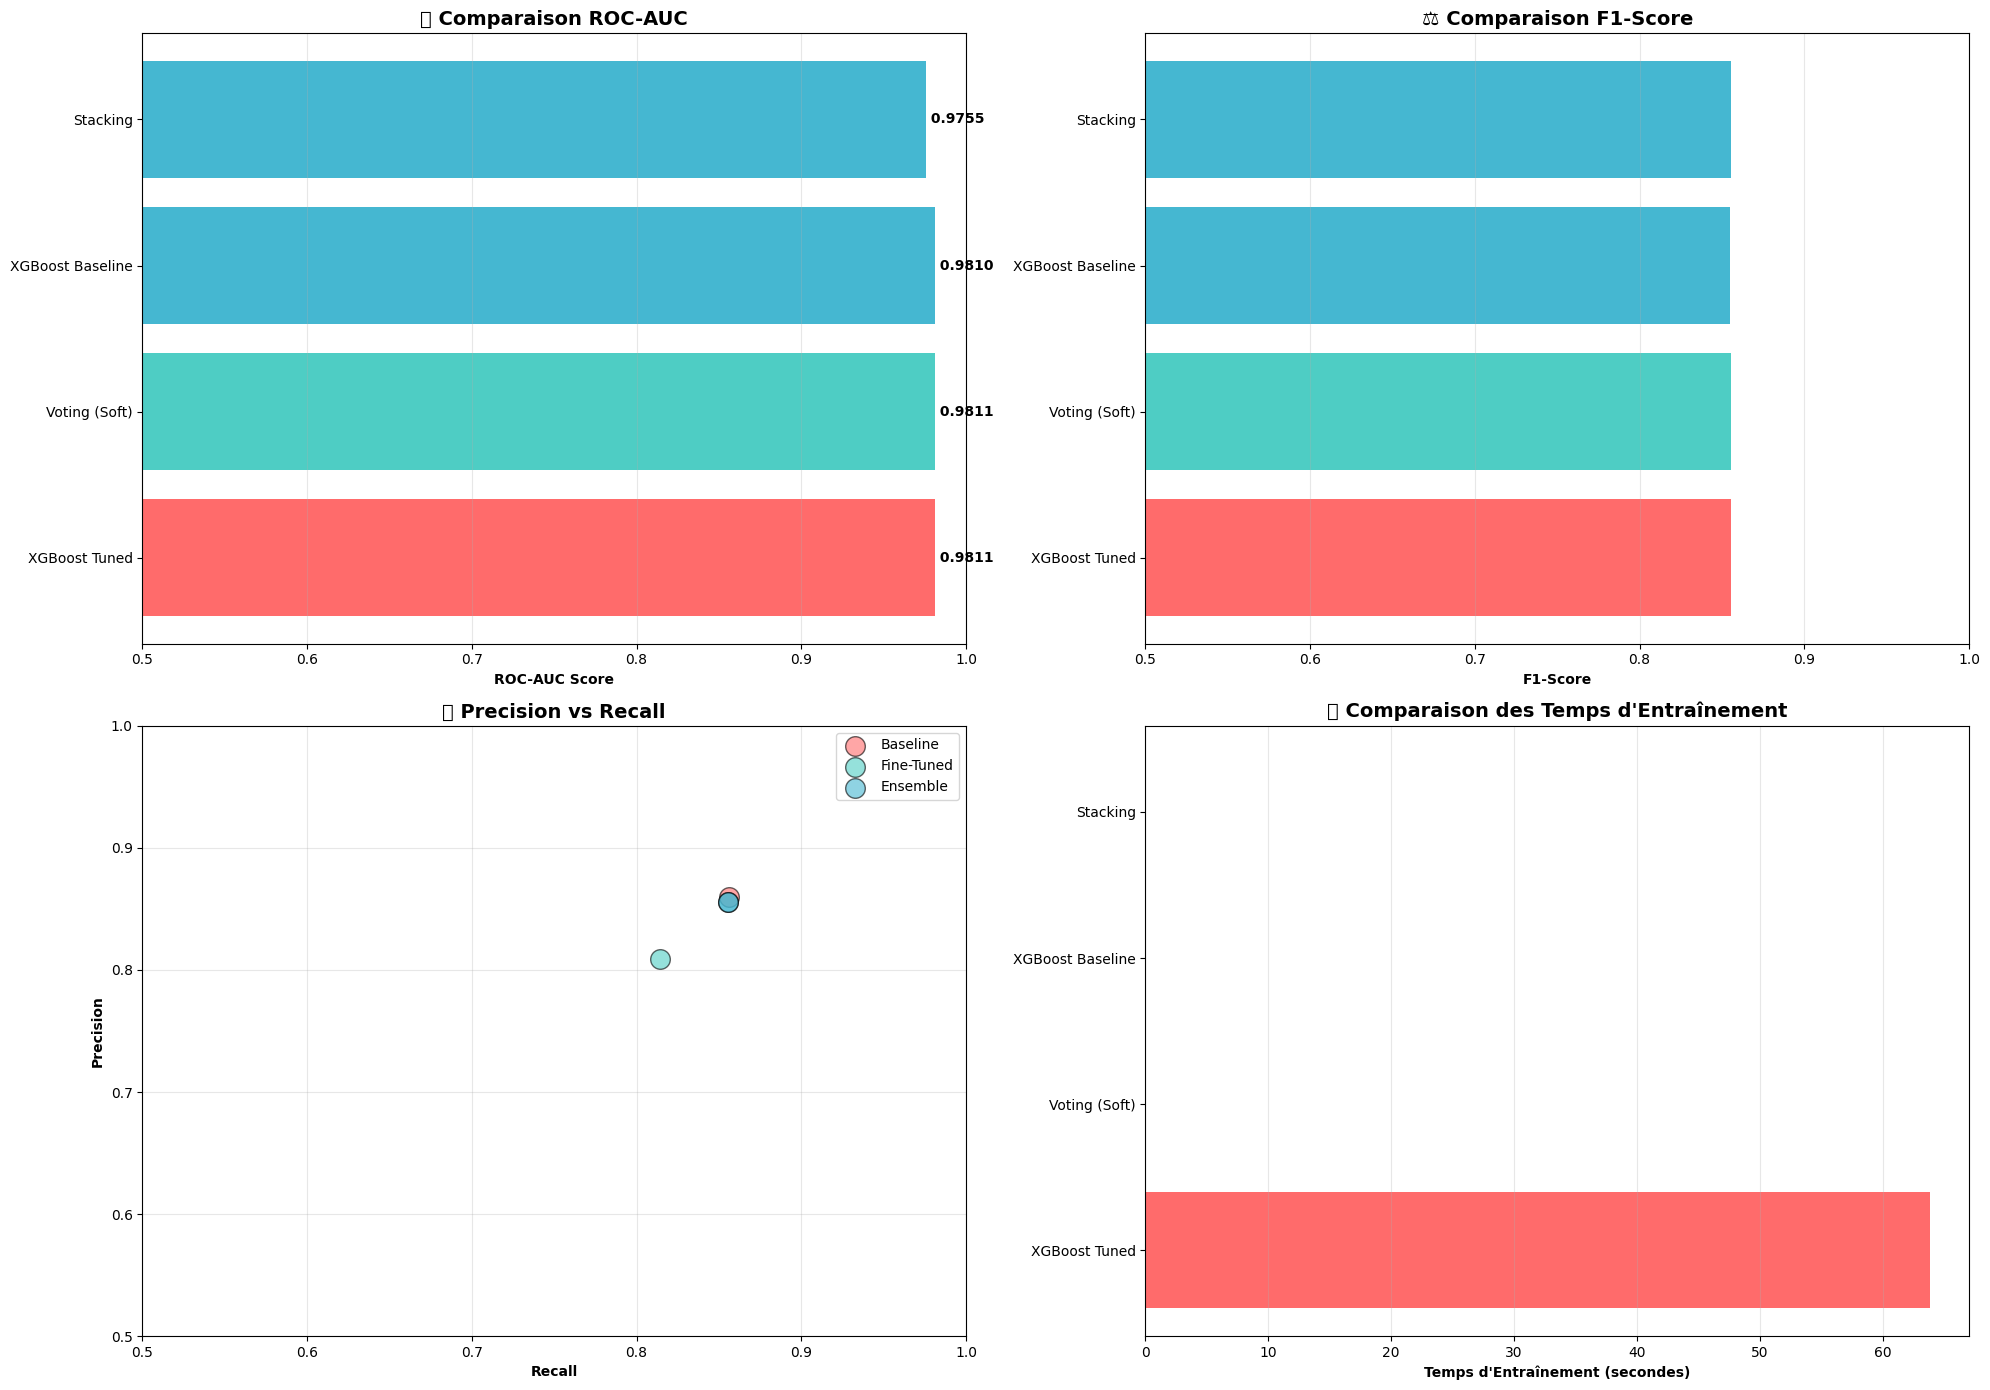

In [38]:
# ===============================
# 🔹 Préparer le DataFrame pour visualisation
# ===============================

df_comparison_vis = df_comparison.copy()

# Ajouter des colonnes manquantes pour l'affichage
df_comparison_vis['Type'] = ['Baseline', 'Fine-Tuned', 'Ensemble', 'Ensemble']  # selon ton modèle
df_comparison_vis['Precision'] = [
    precision_score(y_test, xgb_baseline.predict(X_test_scaled), average='weighted'),
    precision,
    df_results.loc[df_results["Modèle"]=="Stacking","F1-Score"].values[0],  # ou Precision si dispo
    df_results.loc[df_results["Modèle"]=="Voting (Soft)","F1-Score"].values[0]
]
df_comparison_vis['Recall'] = [
    recall_score(y_test, xgb_baseline.predict(X_test_scaled), average='weighted'),
    recall,
    df_results.loc[df_results["Modèle"]=="Stacking","F1-Score"].values[0],  # ou Recall si dispo
    df_results.loc[df_results["Modèle"]=="Voting (Soft)","F1-Score"].values[0]
]
df_comparison_vis['Temps (s)'] = [elapsed, 0, 0, 0]  # mettre tes temps si tu les as

# ===============================
# 🔹 Fonction pour visualisation complète
# ===============================

def plot_comprehensive_comparison(df):
    """
    Visualise la comparaison de tous les modèles (ROC-AUC, F1, Precision vs Recall, Temps)
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Palette de couleurs
    type_colors = {
        'Baseline': '#FF6B6B',
        'Fine-Tuned': '#4ECDC4',
        'Ensemble': '#45B7D1'
    }
    colors = [type_colors[t] for t in df['Type']]
    
    # 1️⃣ ROC-AUC
    axes[0, 0].barh(df['Modèle'], df['ROC-AUC'], color=colors)
    axes[0, 0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0, 0].set_title('🎯 Comparaison ROC-AUC', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlim([0.5, 1.0])
    axes[0, 0].grid(axis='x', alpha=0.3)
    for i, (idx, row) in enumerate(df.iterrows()):
        axes[0, 0].text(row['ROC-AUC'], i, f" {row['ROC-AUC']:.4f}", va='center', fontweight='bold')

    # 2️⃣ F1-Score
    axes[0, 1].barh(df['Modèle'], df['F1-Score'], color=colors)
    axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
    axes[0, 1].set_title('⚖️ Comparaison F1-Score', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0.5, 1.0])
    axes[0, 1].grid(axis='x', alpha=0.3)

    # 3️⃣ Precision vs Recall
    for type_name, color in type_colors.items():
        df_type = df[df['Type'] == type_name]
        axes[1, 0].scatter(df_type['Recall'], df_type['Precision'], 
                           s=200, alpha=0.6, c=color, label=type_name, edgecolors='black')
    axes[1, 0].set_xlabel('Recall', fontweight='bold')
    axes[1, 0].set_ylabel('Precision', fontweight='bold')
    axes[1, 0].set_title('🎯 Precision vs Recall', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0.5, 1.0])
    axes[1, 0].set_ylim([0.5, 1.0])

    # 4️⃣ Training Time
    axes[1, 1].barh(df['Modèle'], df['Temps (s)'], color=colors)
    axes[1, 1].set_xlabel('Temps d\'Entraînement (secondes)', fontweight='bold')
    axes[1, 1].set_title('⏱️ Comparaison des Temps d\'Entraînement', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===============================
# 🔹 Afficher les visualisations
# ===============================
plot_comprehensive_comparison(df_comparison_vis)


C:\Users\asus\AppData\Local\Temp\ipykernel_21776\4271672830.py:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\asus\Desktop\mlops\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


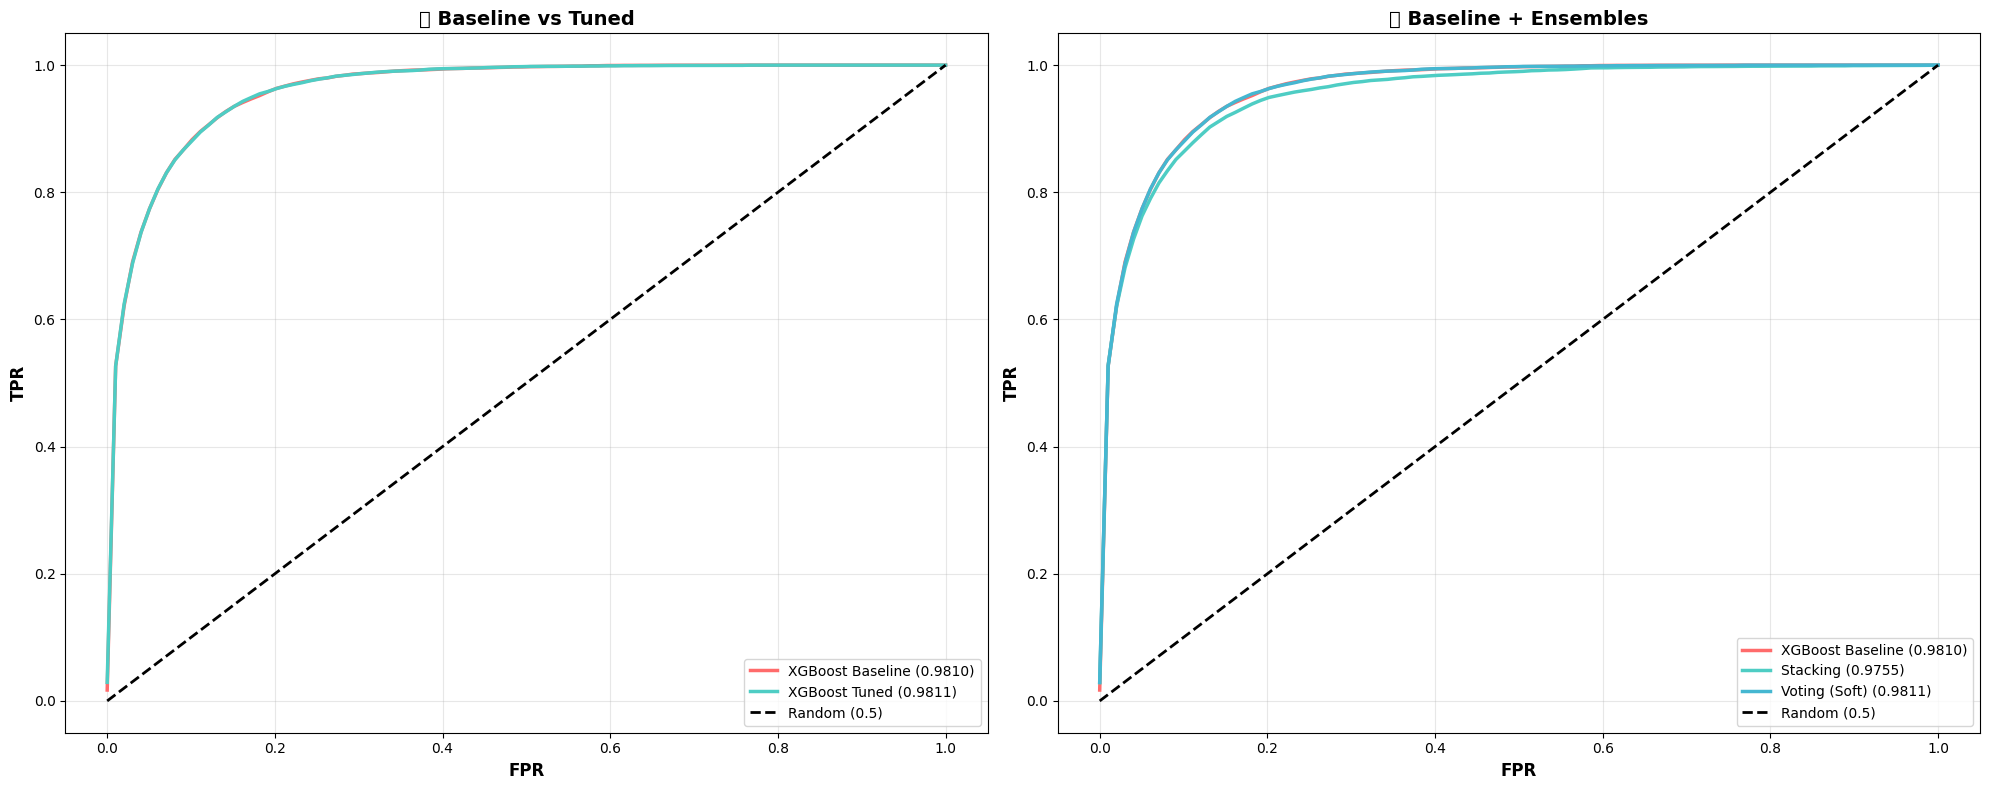

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_baseline_vs_tuned_vs_ensembles(y_test, baseline_model, tuned_model, ensemble_models, n_classes):
    """
    Trace deux courbes ROC :
    1️⃣ Baseline vs Tuned
    2️⃣ Baseline + Ensembles
    """
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    plt.figure(figsize=(20, 8))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    
    # -----------------------
    # Plot 1: Baseline vs Tuned
    # -----------------------
    plt.subplot(1, 2, 1)
    models_plot1 = {
        "XGBoost Baseline": baseline_model,
        "XGBoost Tuned": tuned_model
    }
    
    for idx, (name, model) in enumerate(models_plot1.items()):
        y_proba = model.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='weighted')
        fpr = dict()
        tpr = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
        plt.plot(mean_fpr, mean_tpr, color=colors[idx], lw=2.5,
                 label=f'{name} ({roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (0.5)')
    plt.xlabel('FPR', fontsize=12, fontweight='bold')
    plt.ylabel('TPR', fontsize=12, fontweight='bold')
    plt.title('📈 Baseline vs Tuned', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # -----------------------
    # Plot 2: Baseline + Ensembles
    # -----------------------
    plt.subplot(1, 2, 2)
    models_plot2 = {"XGBoost Baseline": baseline_model}
    models_plot2.update(ensemble_models)
    
    for idx, (name, model) in enumerate(models_plot2.items()):
        y_proba = model.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='weighted')
        fpr = dict()
        tpr = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
        plt.plot(mean_fpr, mean_tpr, color=colors[idx], lw=2.5,
                 label=f'{name} ({roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (0.5)')
    plt.xlabel('FPR', fontsize=12, fontweight='bold')
    plt.ylabel('TPR', fontsize=12, fontweight='bold')
    plt.title('📈 Baseline + Ensembles', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Nombre de classes
n_classes = len(le_target.classes_)

# Appel de la fonction
plot_roc_baseline_vs_tuned_vs_ensembles(y_test, xgb_baseline, best_xgb, ensemble_models, n_classes)


c:\Users\asus\Desktop\mlops\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


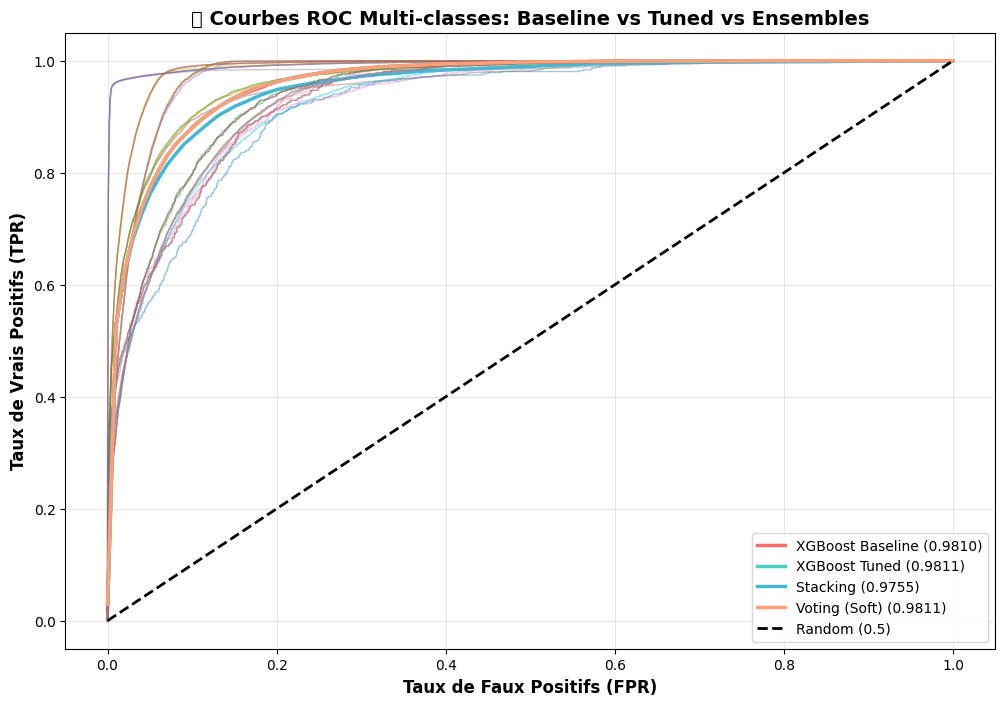

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_comprehensive_roc_curves(y_test, baseline_model, tuned_model, ensemble_models, n_classes):
    """
    Trace les courbes ROC pour tous les modèles (baseline, tuned, ensembles) 
    pour un problème multi-classes en mode 'OvR'.
    """
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    plt.figure(figsize=(12, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    # Liste des modèles
    all_models = {
        "XGBoost Baseline": baseline_model,
        "XGBoost Tuned": tuned_model
    }
    all_models.update(ensemble_models)
    
    for idx, (name, model) in enumerate(all_models.items()):
        y_proba = model.predict_proba(X_test_scaled)
        # ROC-AUC global multi-classe
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='weighted')
        # Moyenne des fpr/tpr pour affichage (OvR)
        fpr = dict()
        tpr = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            plt.plot(fpr[i], tpr[i], alpha=0.4, lw=1)
        # Ajouter la courbe moyenne
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
        plt.plot(mean_fpr, mean_tpr, color=colors[idx % len(colors)], lw=2.5,
                 label=f'{name} ({roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (0.5)')
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    plt.title('📈 Courbes ROC Multi-classes: Baseline vs Tuned vs Ensembles', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

# Nombre de classes
n_classes = len(le_target.classes_)

# Appel de la fonction
plot_comprehensive_roc_curves(y_test, xgb_baseline, best_xgb, ensemble_models, n_classes)
